# **Working memory training**: Second level GLM analysis of working memory training fMRI data

Supplementary analysis - standard GLM analysis of activation patterns changes between 1-back to 2-back. 

In [2]:
import sys
sys.path.append("..")

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import nibabel as nib
from nilearn import input_data, datasets
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_connectome
from nistats.second_level_model import SecondLevelModel
from nistats.reporting import plot_design_matrix, plot_contrast_matrix
from nistats.design_matrix import make_first_level_design_matrix

from fctools import denoise

Step 1: Loading data
--------------------

In [3]:
subjects_data = pd.read_csv('../data/behavioral/group_assignment.csv')
subjects_data_clean = subjects_data[subjects_data['group'].isin(['Experimental', 'Control'])].reset_index()
sessions = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
high_motion = ['sub-13', 'sub-21', 'sub-23', 'sub-50'] # Subjects with high motion in at least one session
high_motion_filter = ~subjects_data_clean['sub'].isin(high_motion).values


data_dir = '/media/finc/Elements/LearningBrain_fmriprep_GLM/'

# Removing high-motion subjects from dataset
subjects_data_clean_lm = subjects_data_clean[~subjects_data_clean['sub'].isin(high_motion)].reset_index()

# Loading zmaps
zmaps= [] 
for i, sub in enumerate(subjects_data_clean_lm['sub']):
    for j, ses in enumerate(sessions):
        zmaps.append(f'{data_dir}{sub}/{ses}/{sub}_{ses}_task-dualnback_bold_space-MNI152NLin2009cAsym_preproc_2b_minus_1b_zmap.nii.gz')

Step 2: Loading Power pacellation
--------------------------------

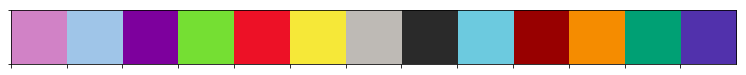

In [9]:
power264 = datasets.fetch_coords_power_2011()
power264_coords = np.vstack((power264.rois['x'], power264.rois['y'], power264.rois['z'])).T

# Creating masker file
power264_maps = input_data.NiftiSpheresMasker(
    seeds = power264_coords, 
    radius = 5,
)

power264_networks = np.asarray(pd.read_csv('../support/modules.txt', header=None)[0])
power264_colors = {'AU':'#d182c6',
                   'CER':'#9fc5e8',
                   'CO':'#7d009d', 
                   'DA':'#75df33', 
                   'DM':'#ed1126', 
                   'FP':'#f6e838', 
                   'MEM':'#bebab5',
                   'SAL':'#2a2a2a',
                   'SOM':'#6ccadf',
                   'SUB':'#980000',
                   'UNC':'#f58c00',
                   'VA':'#00a074', 
                   'VIS':'#5131ac'}

power_palette = (sns.color_palette(power264_colors.values()))
sns.palplot(power_palette)

Step 3: Create design matrix
-------------------------

In [10]:
import itertools

n_sub = len(subjects_data_clean_lm['sub'])

design_matrix = pd.DataFrame()
design_matrix['constant'] = [1] * n_sub * len(sessions)
ses_arr = np.asarray([1,2,3,4])
ses_val = (ses_arr - np.mean(ses_arr))/np.std(ses_arr)
design_matrix['session'] = list(itertools.chain.from_iterable([[i] * n_sub for i in ses_val]))
design_matrix['control'] = list(itertools.chain.from_iterable([(subjects_data_clean_lm['group']=='Control').values.astype(int)]*4))
design_matrix['experimental'] = list(itertools.chain.from_iterable([(subjects_data_clean_lm['group']=='Experimental').values.astype(int)]*4))
ds_sub = np.eye(len(subjects_data_clean_lm['sub']))
ds_subs = pd.DataFrame(np.concatenate([ds_sub, ds_sub, ds_sub, ds_sub]), columns = subjects_data_clean_lm['sub'])

design_matrix = pd.concat((design_matrix, ds_subs), axis=1)

Step 4: Second level GLM analysis
-----------------------------------

In [11]:
second_level_model = SecondLevelModel(smoothing_fwhm=None)

second_level_model = second_level_model.fit(
    zmaps, 
    design_matrix=design_matrix)

Step 5: Contrast analysis
----------------------

In [12]:
# Calculating activation map dor 2-back vs. 1-back contrast (two-sided)
task_effect = np.asarray([1 if i == 'constant' else 0 for i in design_matrix.columns])
group_zmap = second_level_model.compute_contrast(task_effect, output_type='z_score')

# Extracting z-score values for each Power parcellation node
power_zmap = power264_maps.fit_transform(group_zmap)

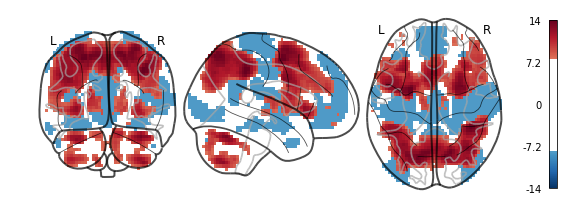

In [13]:
# Plotting activations on glass brain
glass_brain = plot_glass_brain(group_zmap, colorbar=True, display_mode='ortho', plot_abs=False, threshold=8, cmap='RdBu_r')
plt.savefig('../figures/GLM_zmap_glass_brain.png', bbox_inches="tight", dpi=300)

/home/finc/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1752: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


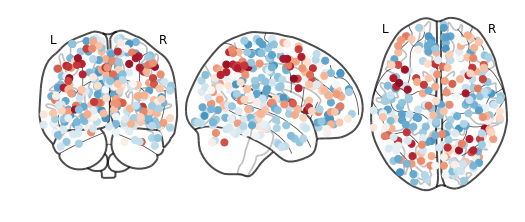

In [14]:
# Visualization on Power ROIs coordinates
norm = plt.Normalize(vmin=-14, vmax=14)
colors = np.squeeze(plt.cm.RdBu_r(norm(power_zmap)))
plot_connectome(np.zeros((264,264)), power264_coords, node_color=colors)

plt.savefig('../figures/GLM_Power_nodes_glass_brain.pdf', bbox_inches="tight", dpi=300)

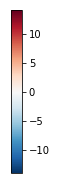

In [15]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(0.2, 3))
cb1 = mpl.colorbar.ColorbarBase(ax, cmap='RdBu_r',
                                norm=norm,
                                orientation='vertical')
plt.savefig('../figures/GLM_colorbar.pdf', bbox_inches="tight", dpi=300)

Step 6: Distribution of activations over large-scale systems
----------------------------------------------------

In [4]:
timeseries = np.load(f'{data_dir}GLM_power_2b_minus_1b_zmap_timeseries.npy')

In [19]:
import matplotlib.pyplot as plt

subjects_data_clean_lm = subjects_data_clean

networks_binary = pd.get_dummies(power264_networks)
mean_zscore_group = pd.DataFrame()

mean_zscore_group_np = np.empty((subjects_data_clean.shape[0], 4, 13))

sessions = ['Naive', 'Early', 'Middle', 'Late']

for i, sub in enumerate(subjects_data_clean_lm['sub']):
    for j, ses in enumerate(sessions):
        for n, net in enumerate(networks_binary.columns):
            
            mean_zscore = timeseries[i, j, networks_binary[net].astype('bool')].mean()
            mean_zscore_group_np[i, j, n] = mean_zscore
            mean_zscore_group = pd.concat([mean_zscore_group, pd.DataFrame({
                "Subject":sub,
                "Session": ses,
                "Group": subjects_data_clean_lm['group'][i],
                "Network": net,
                "Activation": mean_zscore}, index=[0])],   axis=0)
                     
mean_zscore_group.to_csv('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/04-glm/glm_results_all.csv', index=False)
np.save('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/04-glm/glm_results_all.npy', mean_zscore_group_np)

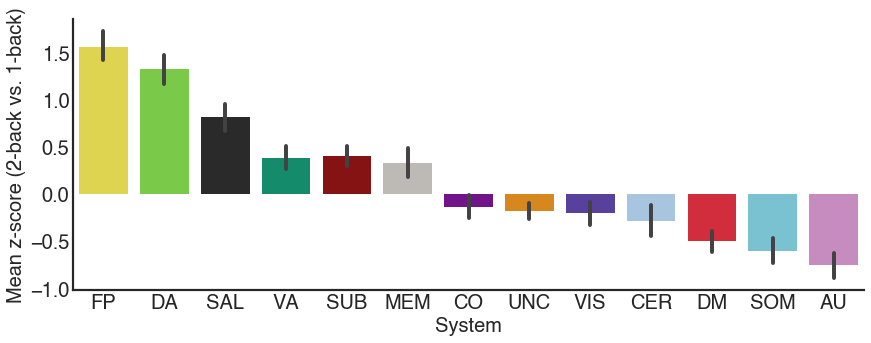

In [35]:
mean_zscore_group_clean = mean_zscore_group[~mean_zscore_group['Subject'].isin(high_motion)]
sort_result = mean_zscore_group.groupby(["Network"])["Activation"].aggregate(np.mean).reset_index().sort_values("Activation", 
                                                                                                                ascending=False)
power_palette_sorted = [power_palette[index] for index in sort_result.index.to_list()]

plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

small = 20
medium = 20
bigger = 20

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', linewidth=2.2)
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title
plt.rc('lines', linewidth=2.2, color='gray')

sns.catplot(x='Network', y='Activation', data=mean_zscore_group_clean, kind="bar", palette=power_palette_sorted, height=5, aspect=2.5, order=sort_result['Network'])
plt.ylabel("Mean z-score (2-back vs. 1-back)")
plt.xlabel("System")
plt.savefig('../figures/GLM_power_networks.pdf', bbox_inches="tight", dpi=300)

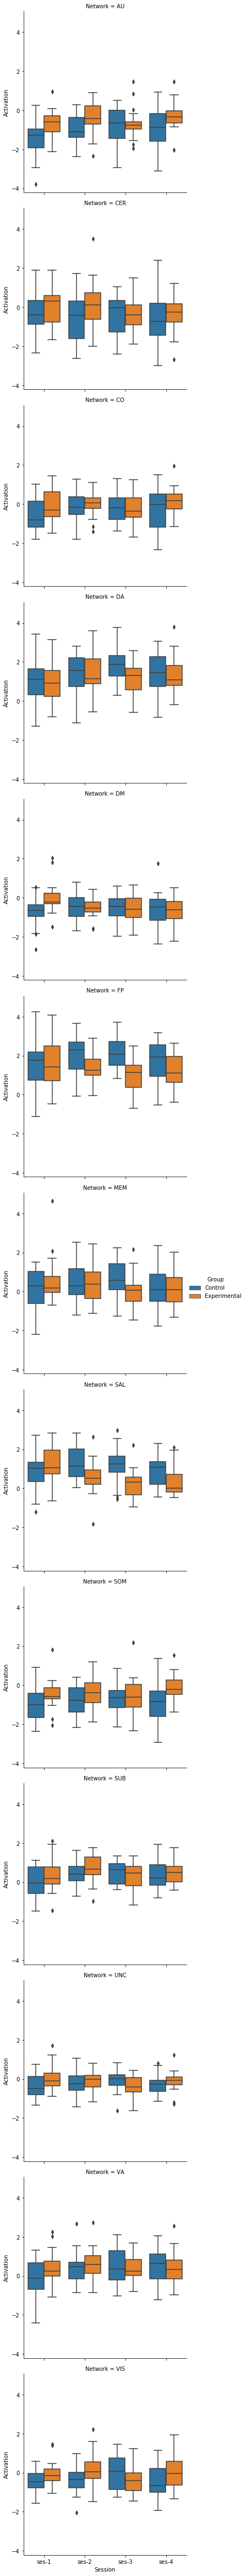

In [192]:
import seaborn as sns

sns.catplot(x='Session', y='Activation', hue='Group', row='Network', data=mean_zscore_group, kind='box')

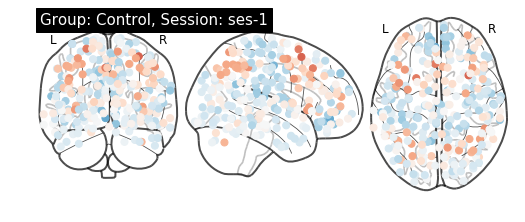

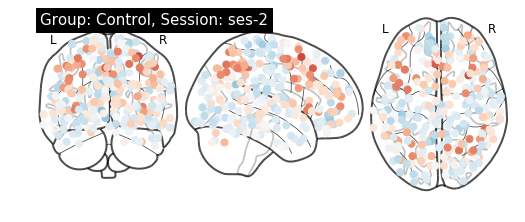

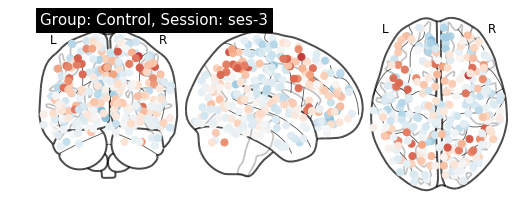

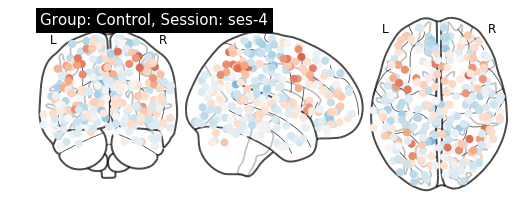

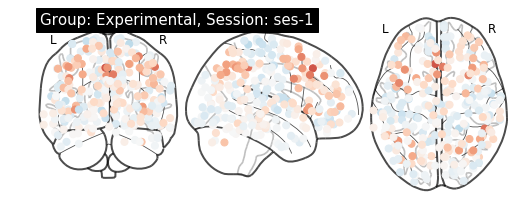

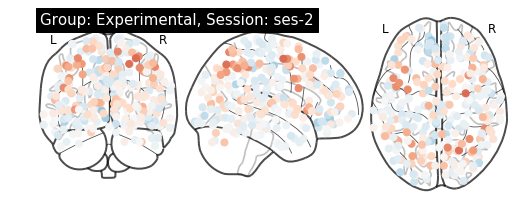

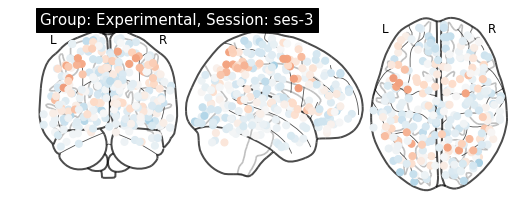

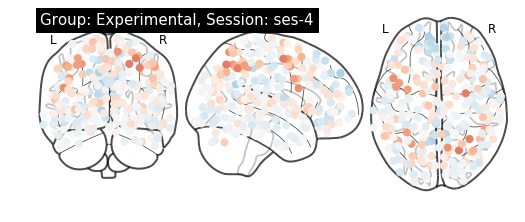

In [31]:
groups = np.unique(subjects_data_clean_lm['group'])

control_filter = (subjects_data_clean_lm['group']=='Control').values
experimental_filter = (subjects_data_clean_lm['group']=='Experimental').values

norm = plt.Normalize(vmin=-5, vmax=5)

for group in groups:
    for s, ses in enumerate(sessions):
        colors = plt.cm.RdBu_r(norm(timeseries_clean[(subjects_data_clean_lm['group']==group).values, s, :].mean(axis=0)))
        plot_connectome(np.zeros((264,264)), power264_coords, node_color=colors, title=f"Group: {group}, Session: {ses}")

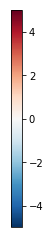

In [102]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(0.2, 4))
cb1 = mpl.colorbar.ColorbarBase(ax, cmap='RdBu_r',
                                norm=norm,
                                orientation='vertical')